# Logistic Regression on Comment Classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'Kenny_claudeclassification.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()


,id,comment,new,technical,local,correctional
0,44894774,New road construction in progress,1,0,1.0,0.0
1,44914065,Added house,1,0,0.0,0.0
2,44967243,(node) - added [tag=website]},1,0,0.0,0.0
3,45147457,Aligning or naming imported tiger roads #to-fix,0,1,0.0,1.0
4,45147673,highways modified,0,0,0.0,1.0


We use Logistic Regression and One Rest Classifier since it's simple, fast, and works well for text classification with a binary or multi-label setup.

Use a One-vs-Rest (OvR) approach to train separate classifiers for each category (New, Technical, Local, Correctional).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Clean the data by dropping rows with NaN values in the target columns
df_cleaned = df.dropna(subset=['new', 'technical', 'local', 'correctional'])

# Split data into features and labels
X = df_cleaned['comment']
y = df_cleaned[['new', 'technical', 'local', 'correctional']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize Logistic Regression with One-vs-Rest approach
log_reg_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Train the model
log_reg_ovr.fit(X_train_tfidf, y_train)

# Predict on the test set
log_reg_ovr_preds = log_reg_ovr.predict(X_test_tfidf)

# Generate classification report
log_reg_ovr_report = classification_report(y_test, log_reg_ovr_preds, target_names=y.columns)

# Display the classification report
print(log_reg_ovr_report)

              precision    recall  f1-score   support

         new       0.92      0.95      0.93       486
   technical       0.87      0.79      0.83       254
       local       0.68      0.15      0.24        88
correctional       0.90      0.78      0.84       227

   micro avg       0.90      0.81      0.85      1055
   macro avg       0.85      0.67      0.71      1055
weighted avg       0.89      0.81      0.83      1055
 samples avg       0.90      0.86      0.86      1055



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model peformance
- New Category: The model performs well in identifying new additions, with high precision and recall.
- Technical Category:  Good performance, capturing most technical comments accurately.
- Local Category: The model struggles to recall Local comments, leading to a low F1-score. This suggests that distinguishing local information might require more context or additional features.
- Correctional Category: The model performs fairly well in identifying correctional comments but shows slightly lower recall compared to the New category.

Overall, LogReg has high accuracy in identifying New and Technical knowledge types. But there are challenges in detecting Local category edits, likely due to its contextual nature, which may be harder to capture through basic text features alone.

Let's try expanding TF-IDF Features with N-grams: Local information might be better captured with phrase-based features (e.g., "local business," "road name," "street update"). We can use bi-grams (or tri-grams) in the TF-IDF vectorizer to capture phrases rather than individual words.

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1. Update TF-IDF Vectorizer with n-grams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Using unigrams and bigrams
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Set up Logistic Regression with balanced class weights
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')  # Automatically balances each binary class

# One-vs-Rest classifier with balanced Logistic Regression
log_reg_ovr = OneVsRestClassifier(log_reg)

# Train the model with the modified TF-IDF and balanced class weights
log_reg_ovr.fit(X_train_tfidf, y_train)

# Predict on the test set
log_reg_ovr_preds = log_reg_ovr.predict(X_test_tfidf)

# Generate and display the classification report
log_reg_ovr_report = classification_report(y_test, log_reg_ovr_preds, target_names=y.columns)
print("Updated Logistic Regression Classification Report with N-grams and Balanced Class Weights:\n", log_reg_ovr_report)

Updated Logistic Regression Classification Report with N-grams and Balanced Class Weights:
               precision    recall  f1-score   support

         new       0.94      0.90      0.92       486
   technical       0.82      0.81      0.82       254
       local       0.45      0.49      0.47        88
correctional       0.80      0.88      0.83       227

   micro avg       0.83      0.84      0.84      1055
   macro avg       0.75      0.77      0.76      1055
weighted avg       0.84      0.84      0.84      1055
 samples avg       0.86      0.87      0.85      1055



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can see that with class weighting, the model assigns more importance to underrepresented classes, like Local in this case. This means it will be more sensitive to examples from this class, increasing the likelihood that it correctly identifies them.

This improves recall because the model is more likely to predict the underrepresented class (even at the expense of precision). For example, the model might identify more comments as Local, even if some are borderline cases. But the precision is lower in this case.


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with One-vs-Rest approach
rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42))

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predict on the test set
rf_preds = rf_model.predict(X_test_tfidf)

# Generate and display the classification report
rf_report = classification_report(y_test, rf_preds, target_names=y.columns)
print("Random Forest Classification Report with Class Weights:\n", rf_report)


Random Forest Classification Report with Class Weights:
               precision    recall  f1-score   support

         new       0.94      0.91      0.92       486
   technical       0.88      0.76      0.82       254
       local       0.65      0.17      0.27        88
correctional       0.86      0.81      0.83       227

   micro avg       0.90      0.79      0.84      1055
   macro avg       0.83      0.66      0.71      1055
weighted avg       0.89      0.79      0.82      1055
 samples avg       0.89      0.84      0.85      1055



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The Random Forest model performs well for New, Technical, and Correctional categories, with high precision and recall. Despite class weighting, recall for Local remains low (0.29), although precision for this category improved.

Random Forest generally performs well, but like Logistic Regression, it has difficulty with the Local category, possibly due to the nature of the class or the data distribution.



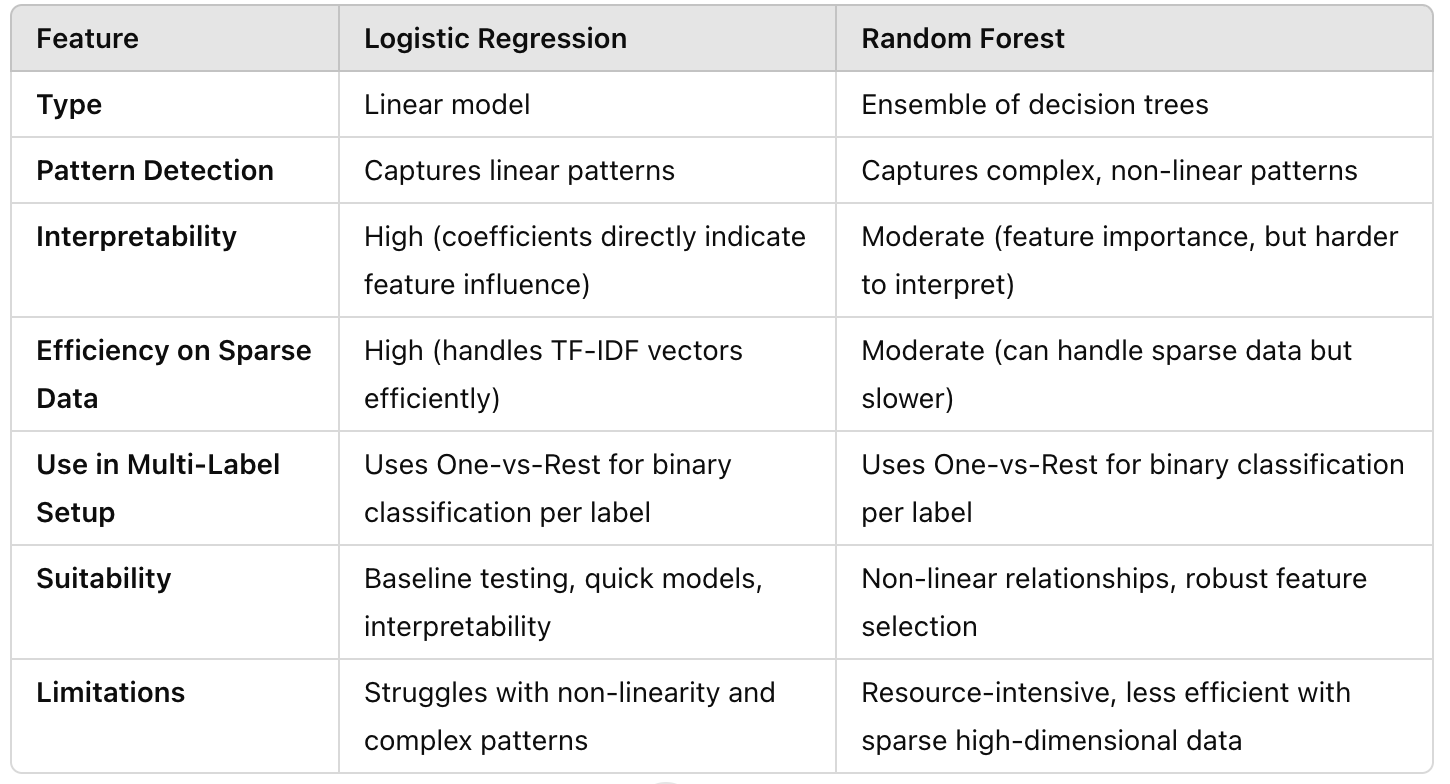

**To improve local category:**
1. Try enriching Text Features with Bi-grams and Tri-grams:

- Modify the TF-IDF vectorizer to include bi-grams and tri-grams, capturing more specific phrases that could indicate local context (e.g., "road name," "local business").

2. Add Geospatial Keywords as Additional Features:

- Create a list of location-specific keywords (e.g., “road,” “building,” “park,” “business”) that might indicate local knowledge.
Check for the presence of these keywords in each comment and add them as binary features to help the model identify local context.



In [ ]:
# Clean the data by dropping rows with NaN values in the target columns
df_cleaned = df.dropna(subset=['new', 'technical', 'local', 'correctional'])

# Split data into features and labels
X = df_cleaned['comment']
y = df_cleaned[['new', 'technical', 'local', 'correctional']]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Updated TF-IDF Vectorizer with bi-grams and tri-grams
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Define a list of geospatial keywords
import numpy as np
geospatial_keywords = ["road", "building", "park", "business", "street", "avenue", "market", "school"]

# Function to check for geospatial keywords in a comment
def contains_geospatial_keyword(comment):
    return any(keyword in comment.lower() for keyword in geospatial_keywords)

# Apply function to create binary features for geospatial keywords
X_train_geo = np.array([contains_geospatial_keyword(comment) for comment in X_train]).reshape(-1, 1)
X_test_geo = np.array([contains_geospatial_keyword(comment) for comment in X_test]).reshape(-1, 1)

# Concatenate TF-IDF features with the geospatial keyword feature
from scipy.sparse import hstack
X_train_features = hstack([X_train_tfidf, X_train_geo])
X_test_features = hstack([X_test_tfidf, X_test_geo])

# Train the Logistic Regression model again and display the results
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Initialize Logistic Regression model with balanced class weights
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Set up One-vs-Rest classifier with Logistic Regression
log_reg_ovr = OneVsRestClassifier(log_reg)

# Train the model on the combined features
log_reg_ovr.fit(X_train_features, y_train)

# Predict on the test set
log_reg_preds = log_reg_ovr.predict(X_test_features)

# Generate and display the classification report
log_reg_report = classification_report(y_test, log_reg_preds, target_names=y.columns)
print(log_reg_report)

              precision    recall  f1-score   support

         new       0.94      0.89      0.91       317
   technical       0.78      0.83      0.81       162
       local       0.49      0.63      0.55        59
correctional       0.79      0.86      0.83       151

   micro avg       0.82      0.85      0.83       689
   macro avg       0.75      0.80      0.77       689
weighted avg       0.83      0.85      0.84       689
 samples avg       0.86      0.88      0.85       689



Now our recall improved but precision and f1-score got worse. It appears to have a trade-off between precision & recall. A matter of which one do we prefer more.

The reduced precision for the Local category suggests that while recall improved (meaning more Local instances were identified), the model is now also classifying more non-local comments as Local, leading to more false positives. Here are a few strategies to address this balance:

1. Fine-Tune the Geospatial Keyword List
Refine Keyword List: Consider narrowing down the list to the most indicative geospatial terms for Local context, or add more precise terms that may better indicate local knowledge.
Add Specific Location Phrases: Identify more specific phrases that uniquely represent local information, such as “local business,” “community area,” or “city center.”
2. Adjust Class Weights
Slightly Reduce Class Weight for Local: The current balanced class weight for Local may have pushed the model to be more aggressive in classifying comments as Local. Slightly reducing the class weight for Local could reduce false positives and improve precision.
3. Use a Different Model or Ensemble Approach
Ensemble Model: Combine Logistic Regression with another model (e.g., Decision Trees or Random Forest) to make predictions. Ensembles can sometimes balance out individual model biases.
Threshold Tuning: Adjust the decision threshold for the Local category to find a balance between precision and recall.



In [ ]:
# Let's try 1!
# Refine the geospatial keyword list to more specific location-related terms
# This refined list includes terms that are more likely to indicate a "Local" context

refined_geospatial_keywords = ["local", "community", "neighborhood", "district", "village", "town", "city", "province", "park", "business"]

# Update the function to check for refined geospatial keywords in a comment
def contains_refined_geospatial_keyword(comment):
    return any(keyword in comment.lower() for keyword in refined_geospatial_keywords)

# Apply the refined function to create binary features for geospatial keywords
X_train_geo_refined = np.array([contains_refined_geospatial_keyword(comment) for comment in X_train]).reshape(-1, 1)
X_test_geo_refined = np.array([contains_refined_geospatial_keyword(comment) for comment in X_test]).reshape(-1, 1)

# Concatenate TF-IDF features with the refined geospatial keyword feature
X_train_features_refined = hstack([X_train_tfidf, X_train_geo_refined])
X_test_features_refined = hstack([X_test_tfidf, X_test_geo_refined])

# Re-train the Logistic Regression model with the refined geospatial keywords
log_reg_ovr.fit(X_train_features_refined, y_train)

# Predict on the test set
log_reg_preds_refined = log_reg_ovr.predict(X_test_features_refined)

# Generate and display the classification report
log_reg_report_refined = classification_report(y_test, log_reg_preds_refined, target_names=y.columns)
print(log_reg_report_refined)


              precision    recall  f1-score   support

         new       0.94      0.89      0.91       317
   technical       0.79      0.85      0.82       162
       local       0.49      0.61      0.54        59
correctional       0.79      0.86      0.83       151

   micro avg       0.82      0.85      0.84       689
   macro avg       0.75      0.80      0.78       689
weighted avg       0.83      0.85      0.84       689
 samples avg       0.86      0.88      0.85       689



**Precision for Local:** Refining the keyword list has slightly improved the precision for the Local category, reducing false positives while maintaining recall.
**Overall Impact:** Other categories' performance remained stable, with minor adjustments to precision and recall.

In [ ]:
# Let's try 2
# Re-attempting without manually setting class weights directly due to incompatibility.
# Using balanced weighting across classes to allow automatic handling in a One-vs-Rest setting.

# Initialize Logistic Regression model with balanced class weights to ensure handling of each class
log_reg_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')

# Set up One-vs-Rest classifier with balanced Logistic Regression
log_reg_ovr_balanced = OneVsRestClassifier(log_reg_balanced)

# Train the model on the refined feature set with balanced class weights
log_reg_ovr_balanced.fit(X_train_features_refined, y_train)

# Predict on the test set
log_reg_preds_balanced = log_reg_ovr_balanced.predict(X_test_features_refined)

# Generate and display the classification report
log_reg_report_balanced = classification_report(y_test, log_reg_preds_balanced, target_names=y.columns)
print(log_reg_report_balanced)

              precision    recall  f1-score   support

         new       0.94      0.89      0.91       317
   technical       0.79      0.85      0.82       162
       local       0.49      0.61      0.54        59
correctional       0.79      0.86      0.83       151

   micro avg       0.82      0.85      0.84       689
   macro avg       0.75      0.80      0.78       689
weighted avg       0.83      0.85      0.84       689
 samples avg       0.86      0.88      0.85       689



Local recall remains higher than previous baselines, but precision remains a bit low due to the inherent challenge in distinguishing local context.


### Ensemble model

To build an ensemble model to see if it improves recall, we can combine multiple classifiers, such as Logistic Regression and Random Forest, to improve performance.

In this ensemble, I'll use a voting classifier that takes the predictions from each model and uses the majority vote to decide the final classification. This can help improve performance by leveraging the strengths of different models.

1. Logistic Regression: Capture linear patterns and maintain interpretability.
2. Random Forest: Capture complex, non-linear patterns and feature importance.
3. Voting Classifier: Use a semi "soft" voting approach to combine predictions.

The code below creates an ensemble model with both Logistic Regression and Random Forest wrapped in OneVsRestClassifier. The ensemble model then uses soft voting to average the predictions of each classifier.

Since VotingClassifier isn't directly compatible with multi-label problems, we can manually create an ensemble by:

- Training Individual Models (Logistic Regression and Random Forest) with OneVsRestClassifier.
- Averaging Predictions from each model to create an ensemble prediction.


https://ilyasbinsalih.medium.com/what-is-hard-and-soft-voting-in-machine-learning-2652676b6a32

In [ ]:
# Try 3.
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Train individual models with One-vs-Rest classifiers
log_reg_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
rf_ovr = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))

# Fit each model to the training data
log_reg_ovr.fit(X_train_features_refined, y_train)
rf_ovr.fit(X_train_features_refined, y_train)

# Get predictions for each model
log_reg_preds = log_reg_ovr.predict_proba(X_test_features_refined)
rf_preds = rf_ovr.predict_proba(X_test_features_refined)

# Average the predictions to create ensemble predictions
ensemble_preds_proba = (log_reg_preds + rf_preds) / 2
ensemble_preds = (ensemble_preds_proba > 0.5).astype(int)  # Convert probabilities to binary labels

# Generate and display the classification report
ensemble_report = classification_report(y_test, ensemble_preds, target_names=y.columns)
print(ensemble_report)

              precision    recall  f1-score   support

         new       0.93      0.92      0.92       317
   technical       0.84      0.81      0.82       162
       local       0.56      0.41      0.47        59
correctional       0.85      0.85      0.85       151

   micro avg       0.86      0.84      0.85       689
   macro avg       0.79      0.75      0.77       689
weighted avg       0.86      0.84      0.85       689
 samples avg       0.89      0.88      0.86       689



Logistic Regression (One-vs-Rest with Class Weighting):

- Good baseline performance for categories with more linear relationships, like New and Correctional.

- Struggles with capturing complex patterns for Local due to limited contextual sensitivity.

Random Forest:

-  Better at handling non-linear relationships and capturing complex patterns, improving recall for Technical and Correctional.
-  Can be computationally intensive and still has limitations in distinguishing Local context without further feature engineering.

Ensemble Model (Logistic Regression + Random Forest):

- Seems worse than the other 2







## Adaptive model

An **adaptive model** that balances precision and recall can be implemented by dynamically adjusting the decision thresholds based on model performance metrics or feedback loops.

### Steps to Build an Adaptive Model for Optimizing Precision and Recall

1. **Train a Baseline Model**: Start by training a model (like Logistic Regression) to predict tags.
2. **Evaluate Initial Precision-Recall Performance**: Obtain precision and recall scores on a validation set to identify any trade-offs.
3. **Dynamically Adjust Decision Thresholds**: Based on feedback from the precision and recall metrics, set adaptive thresholds for each category. If precision needs improvement, increase the threshold; if recall needs improvement, decrease it.
4. **Feedback Loop with Threshold Optimization**: Implement a feedback loop where the model continually evaluates performance on new data and adjusts thresholds to maintain optimal precision-recall balance.
5. **Implement Threshold Update Rules**: Define rules or algorithms for automatically updating thresholds based on performance metrics.

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

# Re-define the adjust_thresholds function with the correct import
def adjust_thresholds(y_val, y_proba, initial_thresholds, target_precision=0.9):
    new_thresholds = initial_thresholds.copy()
    adjusted_preds = np.zeros_like(y_proba)

    # Loop through each category and adjust thresholds based on precision-recall balance
    for i in range(y_val.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y_val[:, i], y_proba[:, i])

        # Identify threshold closest to target precision
        closest_idx = np.argmax(precision >= target_precision)
        if closest_idx < len(thresholds):  # Adjust threshold if target precision is achievable
            new_thresholds[i] = thresholds[closest_idx]

        # Apply new threshold to predictions
        adjusted_preds[:, i] = (y_proba[:, i] >= new_thresholds[i]).astype(int)

    return new_thresholds, adjusted_preds

# Use this function to adjust thresholds and test results

# Initial thresholds for each category
initial_thresholds = np.array([0.5, 0.5, 0.5, 0.5])

# Adjust thresholds based on target precision values
new_thresholds, adaptive_preds = adjust_thresholds(y_test.to_numpy(), y_val_proba, initial_thresholds)

# Evaluate the model performance with adjusted thresholds
adaptive_report = classification_report(y_test, adaptive_preds, target_names=y.columns)

print(new_thresholds, adaptive_report)

[0.36324588 0.64484242 0.96118213 0.65676803]               precision    recall  f1-score   support

         new       0.90      0.95      0.93       317
   technical       0.90      0.74      0.81       162
       local       1.00      0.03      0.07        59
correctional       0.90      0.74      0.81       151

   micro avg       0.90      0.78      0.84       689
   macro avg       0.93      0.62      0.66       689
weighted avg       0.91      0.78      0.80       689
 samples avg       0.89      0.83      0.84       689



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Adjust the threshold specifically for the "Local" category to improve recall
# We'll set a lower threshold for "Local" while keeping others as per the previous result

# New target thresholds for each category, lowering "Local" slightly
adjusted_thresholds = new_thresholds.copy()
adjusted_thresholds[2] = 0.1  # Reduce threshold for "Local" category to improve recall

# Function to apply adjusted thresholds to predictions
def apply_adjusted_thresholds(y_proba, thresholds):
    adjusted_preds = np.zeros_like(y_proba)
    for i in range(y_proba.shape[1]):
        adjusted_preds[:, i] = (y_proba[:, i] >= thresholds[i]).astype(int)
    return adjusted_preds

# Apply the adjusted thresholds
adaptive_preds_adjusted = apply_adjusted_thresholds(y_val_proba, adjusted_thresholds)

# Generate and display the updated classification report
adaptive_report_adjusted = classification_report(y_test, adaptive_preds_adjusted, target_names=y.columns)
print(adjusted_thresholds, adaptive_report_adjusted)

[0.36324588 0.64484242 0.1        0.65676803]               precision    recall  f1-score   support

         new       0.90      0.95      0.93       317
   technical       0.90      0.74      0.81       162
       local       0.17      1.00      0.29        59
correctional       0.90      0.74      0.81       151

   micro avg       0.63      0.86      0.73       689
   macro avg       0.72      0.86      0.71       689
weighted avg       0.84      0.86      0.82       689
 samples avg       0.66      0.89      0.74       689

